# Density Mapping

By: Jonathan Lo <br>
Requested by Ricky <br>
Purpose is to map various Ookla server points onto a world and country map.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import json, re
from bson import json_util
import geopandas
import geoplot
import geoplot.crs as gcrs
import pycountry
import pycountry_convert as pc

In [2]:
# From https://stackoverflow.com/questions/52672598/how-to-read-json-file-containing-objectid-and-isodate-in-python
def read_mongoextjson_file(filename):
    with open(filename, "r", encoding='utf8') as f:
        # read the entire input; in a real application,
        # you would want to read a chunk at a time
        bsondata = '['+f.read()+']'

        # convert the TenGen JSON to Strict JSON
        # here, I just convert the ObjectId and Date structures,
        # but it's easy to extend to cover all structures listed at
        # http://www.mongodb.org/display/DOCS/Mongo+Extended+JSON
        jsondata = re.sub(r'ObjectId\s*\(\s*\"(\S+)\"\s*\)',
                          r'{"$oid": "\1"}',
                          bsondata)
        jsondata = re.sub(r'ISODate\s*\(\s*(\S+)\s*\)',
                          r'{"$date": \1}',
                          jsondata)
        jsondata = re.sub(r'NumberInt\s*\(\s*(\S+)\s*\)',
                          r'{"$numberInt": "\1"}',
                          jsondata)

        # now we can parse this as JSON, and use MongoDB's object_hook
        # function to get rich Python data structures inside a dictionary
        data = json.loads(jsondata, object_hook=json_util.object_hook)

        return data

In [3]:
# Reading data
data = read_mongoextjson_file('ookladata.json')[0]
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [4]:
# Small filtering
df = pd.DataFrame(data)
drop_col = ['host', 'ipv4', 'ipv6', 'asnv4', 'asnv6', 'enabled', 'lastupdated', 'id', '_id', 'type', 'identifier', 'additional']
df.drop(drop_col, axis=1, inplace=True)
df

,location,country,city
0,"{'type': 'Point', 'coordinates': [-95.4247, 39...",US,"Everest, KS"
1,"{'type': 'Point', 'coordinates': [-94.4611, 43...",US,"Fairmont, MN"
2,"{'type': 'Point', 'coordinates': [-105.5192, 4...",US,"Estes Park, CO"
3,"{'type': 'Point', 'coordinates': [-107.3167, 3...",US,"Glenwood Springs, CO"
4,"{'type': 'Point', 'coordinates': [-88.2612, 40...",US,"Champaign, IL"
...,...,...,...
13918,"{'type': 'Point', 'coordinates': [78.0081, 27....",IN,Agra
13919,"{'type': 'Point', 'coordinates': [75.2352, 29....",IN,Sardulgarh
13920,"{'type': 'Point', 'coordinates': [84.36, 26.22...",IN,Siwan
13921,"{'type': 'Point', 'coordinates': [-46.2564, -2...",BR,Guarujá


In [5]:
# Clean location data
def clean_location(location):
    return location['coordinates']
df['coords'] = df['location'].apply(clean_location)
cols = pd.DataFrame(df['coords'].tolist(), columns=['lat', 'long'])
df = pd.concat([df, cols], axis=1, join='inner')

In [6]:
# Turn into GeoDF
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lat, df.long))
gdf.drop(['lat', 'long', 'coords', 'city', 'location'], axis=1, inplace=True)

C:\Users\jonat\anaconda3\envs\geopandas_env\lib\site-packages\geoplot\geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
C:\Users\jonat\anaconda3\envs\geopandas_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\jonat\anaconda3\envs\geopandas_env\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

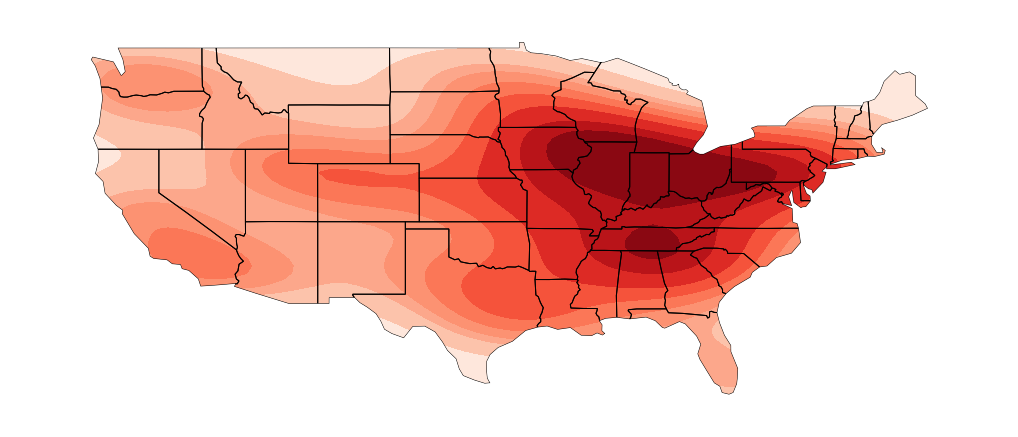

In [7]:
# Plotting the United States map
contiguous_usa = geopandas.read_file(geoplot.datasets.get_path('contiguous_usa'))
us_data = gdf.loc[gdf.country == 'US']
ax = geoplot.kdeplot(us_data, shade=True, thresh=0, clip=contiguous_usa.geometry, cmap='Reds', figsize=(18, 12))

geoplot.polyplot(contiguous_usa, ax=ax, zorder=1)

In [8]:
# Dropping Kosovo and others 
gdf_filtered = gdf.loc[gdf['country'] != 'XC']
gdf_filtered = gdf_filtered.loc[gdf['country'] != 'UK']
gdf_filtered = gdf_filtered.loc[gdf['country'] != 'SX']
gdf_filtered = gdf_filtered.loc[gdf['country'] != 'TL']

In [9]:
# Assigning countries continents
def country_to_continent(iso_2):
    try:
        return pc.country_alpha2_to_continent_code(iso_2)
    except:
        print(iso_2)
gdf_filtered['continent'] = gdf_filtered['country'].apply(country_to_continent)

In [10]:
# Assigning continents to increase granularity when plotting
na = gdf_filtered[gdf_filtered['continent'] == 'NA']
sa = gdf_filtered[gdf_filtered['continent'] == 'SA']
asia = gdf_filtered[gdf_filtered['continent'] == 'AS']
oc = gdf_filtered[gdf_filtered['continent'] == 'OC']
af = gdf_filtered[gdf_filtered['continent'] == 'AF']
eu = gdf_filtered[gdf_filtered['continent'] == 'EU']

In [11]:
# Creating count table to vary color
counts = gdf_filtered.groupby('continent').count()
for index, row in counts.iterrows():
    print(f"{index}: {row['country']/4874}")

AF: 0.07263028313500206
AS: 0.6702913418137054
EU: 0.6169470660648338
NA: 0.4505539597866229
OC: 0.0449322938038572
SA: 1.0


In [24]:
z = build_custom_continuous_cmap([255,255,255],[255,255,255])

In [21]:
world['zeros'] = 0

C:\Users\jonat\anaconda3\envs\geopandas_env\lib\site-packages\geoplot\geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


<AxesSubplot:>

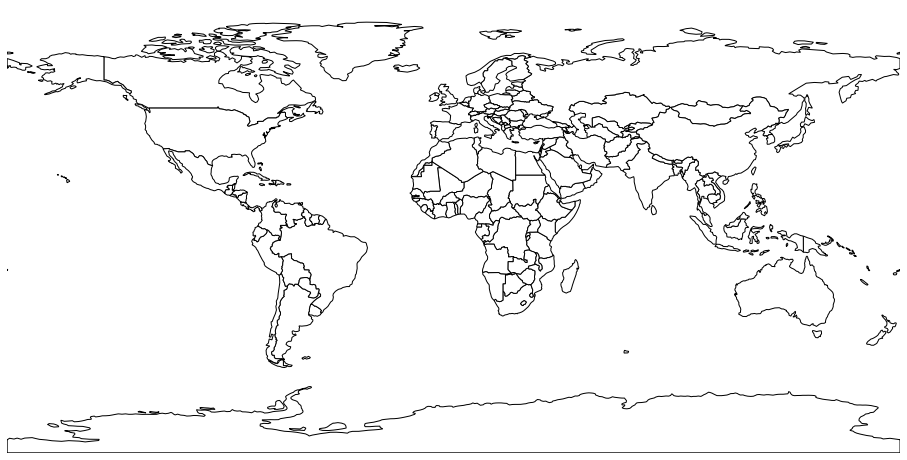

In [25]:
geoplot.choropleth(world, hue='zeros', figsize=(16,12), cmap=z)

In [12]:
# From https://github.com/frankligy/scTriangulate/blob/main/sctriangulate/colors.py
# Created by Frank Li (https://frankligy.medium.com/)
def build_custom_continuous_cmap(*rgb_list):
    # 256 to [0,1]
    def inter_from_256(x):
        return np.interp(x=x,xp=[0,255],fp=[0,1])

    # [0,1] to 256
    def infer_to_256(x):
        return int(np.interp(x=x,xp=[0,1],fp=[0,255]))
    all_red = []
    all_green = []
    all_blue = []
    for rgb in rgb_list:
        all_red.append(rgb[0])
        all_green.append(rgb[1])
        all_blue.append(rgb[2])
    # build each section
    n_section = len(all_red) - 1
    red = tuple([(1/n_section*i,inter_from_256(v),inter_from_256(v)) for i,v in enumerate(all_red)])
    green = tuple([(1/n_section*i,inter_from_256(v),inter_from_256(v)) for i,v in enumerate(all_green)])
    blue = tuple([(1/n_section*i,inter_from_256(v),inter_from_256(v)) for i,v in enumerate(all_blue)])
    cdict = {'red':red,'green':green,'blue':blue}
    new_cmap = colors.LinearSegmentedColormap('new_cmap',segmentdata=cdict)
    return new_cmap

In [13]:
# Obtaining cutoff vals for new cmaps
AF = int(255*0.07263028313500206)
AS = int(255*0.6702913418137054)
EU = int(255*0.6169470660648338)
NA = int(255*0.4505539597866229)
OC = int(255*0.0449322938038572)
SA = int(255*1.0)

In [14]:
# Obtaining rgb list for cmaps
def obtain_rgb_list(cutoff):
    red = cm.get_cmap('Reds', 255)
    red_rgb_array = red(range(256), bytes=True)
    indicies = []
    colors = []
    for i in range(0, cutoff, int(cutoff/10)):
        indicies += [i]
    for i in indicies:
        temp = red_rgb_array[i]
        colors += [[temp[0], temp[1], temp[2]]]
    return colors

AF_list = obtain_rgb_list(AF)
AS_list = obtain_rgb_list(AS)
EU_list = obtain_rgb_list(EU)
NA_list = obtain_rgb_list(NA)
OC_list = obtain_rgb_list(OC)

In [15]:
# Displaying to paste into function
print(f"AF:\n{AF_list}")
print(f"AS:\n{AS_list}")
print(f"EU:\n{EU_list}")
print(f"NA:\n{NA_list}")
print(f"OC:\n{OC_list}")

AF:
[[255, 245, 240], [254, 244, 239], [254, 243, 238], [254, 243, 237], [254, 242, 236], [254, 241, 235], [254, 241, 234], [254, 240, 233], [254, 239, 232], [254, 239, 231], [254, 238, 230], [254, 237, 229], [254, 237, 228], [254, 236, 227], [254, 235, 226], [254, 235, 225], [254, 234, 224], [254, 233, 223]]
AS:
[[255, 245, 240], [254, 233, 223], [253, 221, 206], [252, 201, 180], [252, 181, 154], [252, 159, 129], [251, 137, 105], [251, 116, 84], [247, 92, 65], [241, 67, 49]]
EU:
[[255, 245, 240], [254, 235, 225], [254, 225, 211], [253, 208, 189], [252, 191, 166], [252, 172, 143], [252, 152, 121], [251, 133, 101], [251, 114, 82], [247, 94, 66], [242, 71, 52]]
NA:
[[255, 245, 240], [254, 237, 229], [254, 230, 219], [253, 222, 208], [253, 209, 191], [252, 196, 174], [252, 183, 157], [252, 169, 141], [252, 155, 124], [251, 141, 109], [251, 127, 95]]
OC:
[[255, 245, 240], [254, 244, 239], [254, 243, 238], [254, 243, 237], [254, 242, 236], [254, 241, 235], [254, 241, 234], [254, 240, 233], 

In [16]:
# Creating cmaps using previous rgb lists
AF_cmap = build_custom_continuous_cmap([255, 245, 240], [254, 244, 239], [254, 243, 238], [254, 243, 237], [254, 242, 236], [254, 241, 235], [254, 241, 234], [254, 240, 233], [254, 239, 232], [254, 239, 231], [254, 238, 230], [254, 237, 229], [254, 237, 228], [254, 236, 227], [254, 235, 226], [254, 235, 225], [254, 234, 224], [254, 233, 223])
AS_cmap = build_custom_continuous_cmap([255, 245, 240], [254, 233, 223], [253, 221, 206], [252, 201, 180], [252, 181, 154], [252, 159, 129], [251, 137, 105], [251, 116, 84], [247, 92, 65], [241, 67, 49])
EU_cmap = build_custom_continuous_cmap([255, 245, 240], [254, 235, 225], [254, 225, 211], [253, 208, 189], [252, 191, 166], [252, 172, 143], [252, 152, 121], [251, 133, 101], [251, 114, 82], [247, 94, 66], [242, 71, 52])
NA_cmap = build_custom_continuous_cmap([255, 245, 240], [254, 237, 229], [254, 230, 219], [253, 222, 208], [253, 209, 191], [252, 196, 174], [252, 183, 157], [252, 169, 141], [252, 155, 124], [251, 141, 109], [251, 127, 95])
OC_cmap = build_custom_continuous_cmap([255, 245, 240], [254, 244, 239], [254, 243, 238], [254, 243, 237], [254, 242, 236], [254, 241, 235], [254, 241, 234], [254, 240, 233], [254, 239, 232], [254, 239, 231], [254, 238, 230])
cmaps = [NA_cmap, 'Reds', AS_cmap, OC_cmap, AF_cmap, EU_cmap]

C:\Users\jonat\anaconda3\envs\geopandas_env\lib\site-packages\geoplot\geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
C:\Users\jonat\anaconda3\envs\geopandas_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\jonat\anaconda3\envs\geopandas_env\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\jonat\anaconda3\envs\geopandas_env\lib\site-packages\geoplot\geoplot.py:903: ShapelyDeprecationW

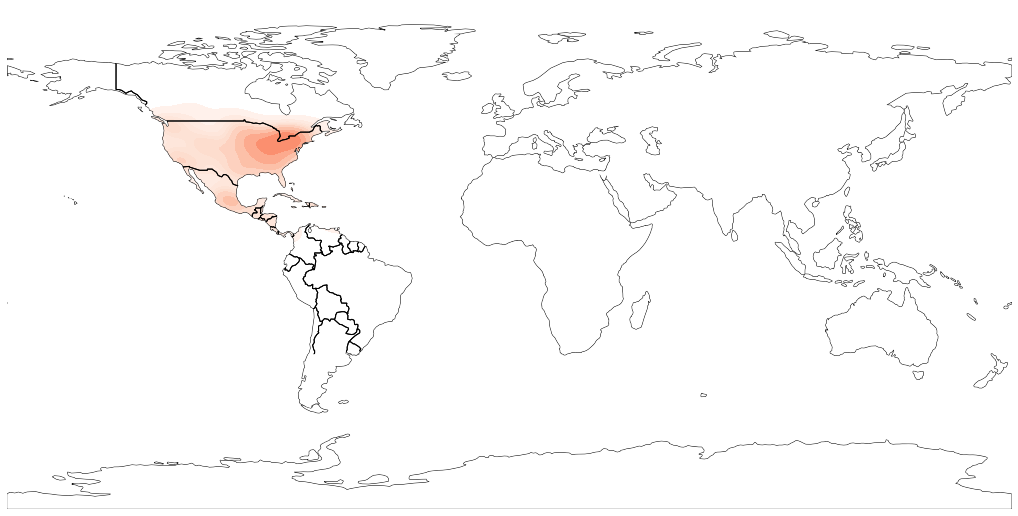

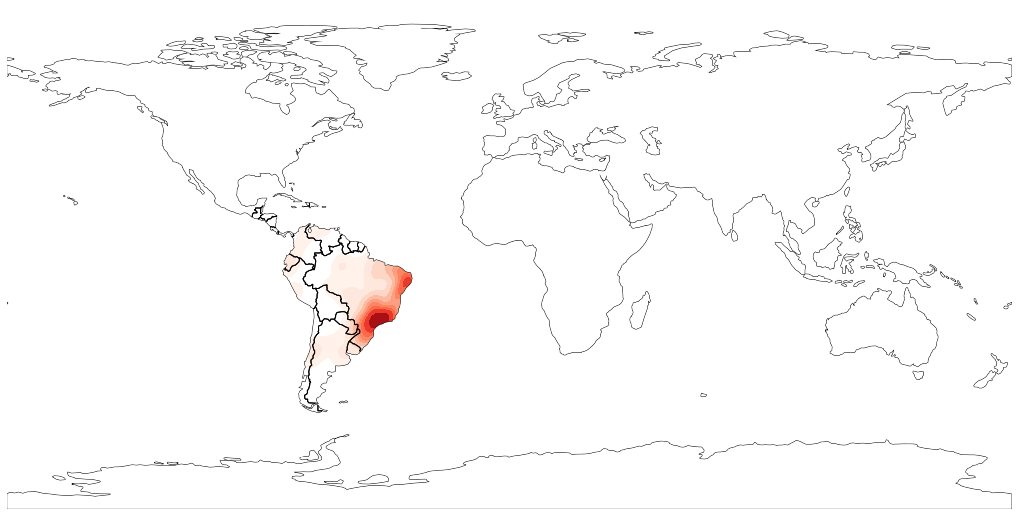

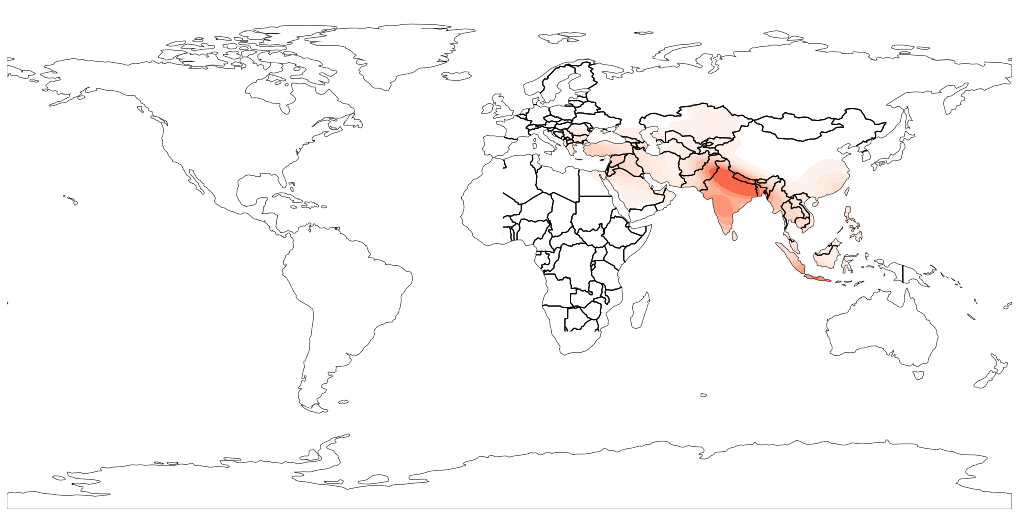

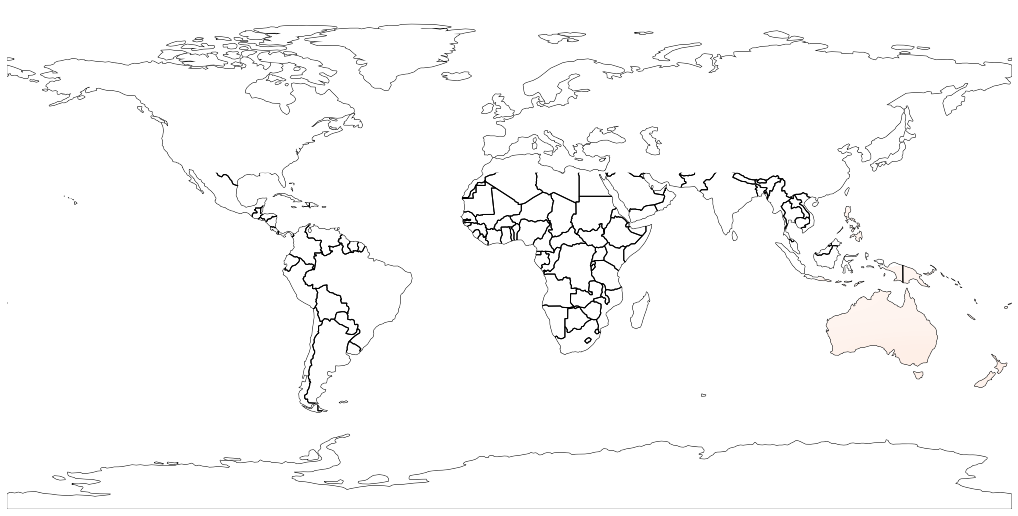

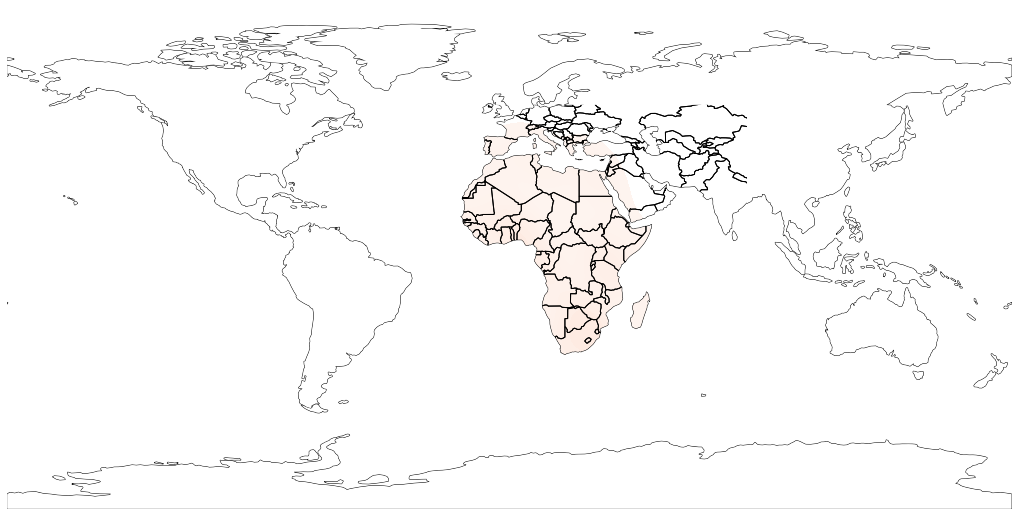

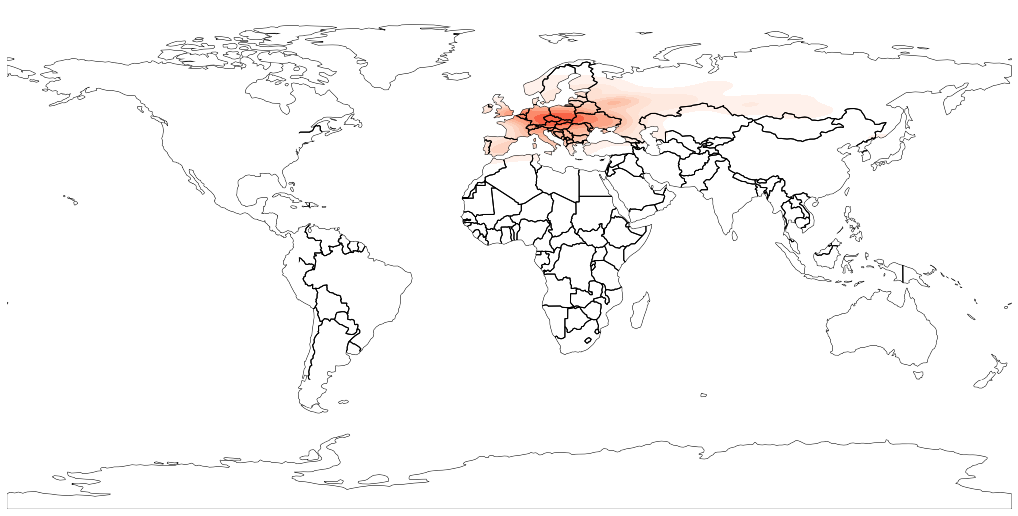

In [17]:
# Plotting multiple continents
continents = [na, sa, asia, oc, af, eu]
for i, continent in enumerate(continents):
    ax = geoplot.kdeplot(continent, shade=True, clip=world.geometry, cmap=cmaps[i], figsize=(18, 12))
    geoplot.polyplot(world, ax=ax, zorder=1)